# Project Data Mining 

## USE CASE
In our case study, we are a company that sells hand tools for the metalworking industry. The company aims to establish a presence in the US market. To achieve this, we are examining data to determine which municipalities are most suitable for us.

## Step 0: Import librarys 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.spatial.distance import cdist
from math import pi
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib.colors import ListedColormap

1.1 load files

In [2]:
df_gdp= pd.read_pickle('gdppickle.sec')
df_occ= pd.read_pickle('naics_occupationpickle.sec')
df_pattern= pd.read_pickle('naics_patternpickle.sec')

## Step 1: Data Understanding

Objective: Analyze the three different data frames and determine which data is suitable for clustering.
Understand the data, the quantity and quality .

Important idicators for the data.

FIPS -> shows the US State and County, should be 5 digits long

NAICS -> classifys businesss establishments, 2 digits -> sector, rest Industry Group

SOC -> the occupation code, 6 digits

#### Only the naics sector 11,21,22,23,31- 33 are relevant








In [4]:
print("gdp shape", df_gdp.shape," occ shape", df_occ.shape, " pattern shape", df_pattern.shape)

gdp shape (108052, 14)  occ shape (1108336, 8)  pattern shape (54727, 26)


High data quantity

### Data Understanding GDP


In [3]:
df_gdp1=df_gdp.copy()

In [6]:
df_gdp.head()

,FIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,2017,2018,2019,2020,2021,2022
0,0,United States,,CAGDP9,1,...,All industry total,Thousands of chained 2017 dollars,1.961210e+10,2.019390e+10,2.069209e+10,2.023407e+10,2.140769e+10,2.182204e+10
1,0,United States,,CAGDP9,2,...,Private industries,Thousands of chained 2017 dollars,1.715626e+10,1.771178e+10,1.819575e+10,1.776187e+10,1.890945e+10,1.928312e+10
2,0,United States,,CAGDP9,3,11,"Agriculture, forestry, fishing and hunting",Thousands of chained 2017 dollars,1.768400e+08,1.841050e+08,1.711490e+08,1.736590e+08,1.837420e+08,1.700580e+08
3,0,United States,,CAGDP9,6,21,"Mining, quarrying, and oil and gas extraction",Thousands of chained 2017 dollars,2.673020e+08,2.770130e+08,3.146040e+08,3.055880e+08,2.694780e+08,2.452900e+08
4,0,United States,,CAGDP9,10,22,Utilities,Thousands of chained 2017 dollars,3.137110e+08,3.092690e+08,3.129200e+08,3.323360e+08,3.166030e+08,3.183920e+08


### Find out the Null values in an data frame and the type of each column

In [7]:
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108052 entries, 0 to 108051
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   FIPS                    108052 non-null  int64  
 1   GeoName                 108052 non-null  object 
 2   Region                  108052 non-null  object 
 3   TableName               108052 non-null  object 
 4   LineCode                108052 non-null  int64  
 5   IndustryClassification  108052 non-null  object 
 6   Description             108052 non-null  object 
 7   Unit                    108052 non-null  object 
 8   2017                    89946 non-null   float64
 9   2018                    90011 non-null   float64
 10  2019                    89731 non-null   float64
 11  2020                    89941 non-null   float64
 12  2021                    90131 non-null   float64
 13  2022                    90103 non-null   float64
dtypes: float64(6), int64

### Analyze the FIPS CODE

In [11]:
FIPS=df_gdp['FIPS'].astype(str).apply(len)
FIPS.unique()

array([1, 4, 5], dtype=int64)

There are 3 different FIPS Digit types. We want to analyze on county level so only the 5 digits will be important

### Analyze the naics sector code

In [12]:
df_gdp['IndustryClassification'].unique()

array(['...', '11', '21', '22', '23', '31-33', '321,327-339',
       '311-316,322-326', '42', '44-45', '48-49', '51', '52,53', '52',
       '53', '54,55,56', '54', '55', '56', '61,62', '61', '62', '71,72',
       '71', '72', '81', '92', '11,21', '42,44-45', '22,48-49',
       '31-33,51'], dtype=object)

## Data Understanding Occupation

In [13]:
df_occ.head()

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation
0,13073,13,2373,"Highway, Street, and Bridge Construction",27,11-3051,Industrial Production Managers,0.022497
1,13073,13,2381,"Foundation, Structure, and Building Exterior C...",231,11-3051,Industrial Production Managers,0.067490
2,13073,13,2382,Building Equipment Contractors,868,11-3051,Industrial Production Managers,0.134981
3,13073,13,2383,Building Finishing Contractors,281,11-3051,Industrial Production Managers,0.078739
5,13073,13,3211,Sawmills and Wood Preservation,116,11-3051,Industrial Production Managers,0.978609


### Check Missing values

In [14]:
df_occ.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1108336 entries, 0 to 1820152
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   FIPS                    1108336 non-null  int64  
 1   State_GEOID             1108336 non-null  int64  
 2   naics                   1108336 non-null  object 
 3   NAICS_TITLE             1108336 non-null  object 
 4   emp_total_county_naics  1108336 non-null  int64  
 5   OCC_CODE                1108336 non-null  object 
 6   OCC_TITLE               1108336 non-null  object 
 7   emp_occupation          1108336 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 76.1+ MB


### Analyze the FIPS

In [16]:
FIPS= df_occ['FIPS'].astype(str).apply(len)
FIPS.unique()

array([5, 4], dtype=int64)

### Analyze the naics

In [18]:
df_occ['naics'].unique()

array(['2373', '2381', '2382', '2383', '3211', '3219', '3231', '3327',
       '3363', '3370A1', '3391', '4231', '4238', '4413', '5413', '5612',
       '5613', '8111', '8113', '1133', '3320A2', '2211', '2362', '2371',
       '3261', '3399', '4881', '3250A1', '2123', '2379', '3119', '3222',
       '3241', '3320A1', '3328', '3330A1', '3333', '3345', '3364', '4882',
       '3362', '3132', '3262', '3344', '2212', '3335', '3212', '2131',
       '3366', '2111', '3311', '3312', '3313', '3314', '3315', '3336',
       '3361', '3365', '4861', '4862', '2121', '4811', '2122', '4411',
       '5617', '4812', '4412', '5321', '7139'], dtype=object)

### Analyze the OCC Code

In [19]:
df_occ['OCC_CODE'].unique()

array(['11-3051', '17-2011', '17-2112', '17-2121', '17-2131', '17-2141',
       '17-2151', '17-3021', '17-3026', '17-3027', '45-2091', '45-4021',
       '45-4022', '47-2011', '47-2043', '47-2211', '47-2221', '47-5012',
       '47-5013', '47-5022', '47-5041', '47-5044', '47-5049', '47-5051',
       '49-3011', '49-3021', '49-3023', '49-3031', '49-3041', '49-3042',
       '49-3043', '49-3051', '49-3052', '49-3093', '49-9041', '49-9043',
       '49-9044', '49-9071', '49-9081', '51-2011', '51-2031', '51-2041',
       '51-4021', '51-4022', '51-4023', '51-4031', '51-4032', '51-4033',
       '51-4034', '51-4035', '51-4041', '51-4051', '51-4052', '51-4061',
       '51-4062', '51-4071', '51-4072', '51-4081', '51-4111', '51-4121',
       '51-4122', '51-4191', '51-4193', '51-4194', '51-4199', '51-7031',
       '51-7042', '51-7099', '51-9021', '51-9022', '51-9031', '51-9032',
       '51-9041', '51-9051', '51-9081', '51-9082', '51-9195', '47-5011',
       '51-7032', '47-5043'], dtype=object)

If you check the source you will notice that there are many occupations not relevant for the use case

## Data Understanding pattern

In [20]:
df_pattern.head()

,State_GEOID,County_GEOID,FIPS,naics_2,naics,DESCRIPTION,emp_nf,emp,qp1_nf,qp1,...,n20_49,n50_99,n100_249,n250_499,n500_999,n1000,n1000_1,n1000_2,n1000_3,n1000_4
0,01,001,1001,11,1133,Logging,G,68,G,1213,...,N,N,N,N,N,N,N,N,N,N
1,01,001,1001,21,2123,Nonmetallic Mineral Mining and Quarrying,G,87,G,1224,...,N,N,N,N,N,N,N,N,N,N
2,01,001,1001,22,2211,"Electric Power Generation, Transmission and Di...",G,129,G,4418,...,N,N,N,N,N,N,N,N,N,N
4,01,001,1001,23,2362,Nonresidential Building Construction,H,69,H,685,...,N,N,N,N,N,N,N,N,N,N
5,01,001,1001,23,2371,Utility System Construction,H,65,H,1117,...,N,N,N,N,N,N,N,N,N,N


In [21]:
df_pattern.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54727 entries, 0 to 188589
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   State_GEOID   54727 non-null  object
 1   County_GEOID  54727 non-null  object
 2   FIPS          54727 non-null  int64 
 3   naics_2       54727 non-null  object
 4   naics         54727 non-null  object
 5   DESCRIPTION   54727 non-null  object
 6   emp_nf        54727 non-null  object
 7   emp           54727 non-null  int64 
 8   qp1_nf        54727 non-null  object
 9   qp1           54727 non-null  int64 
 10  ap_nf         54727 non-null  object
 11  ap            54727 non-null  int64 
 12  est           54727 non-null  int64 
 13  n<5           54727 non-null  object
 14  n5_9          54727 non-null  object
 15  n10_19        54727 non-null  object
 16  n20_49        54727 non-null  object
 17  n50_99        54727 non-null  object
 18  n100_249      54727 non-null  object
 19  n250_499

Again, there are no missing values, but if you check the source you will notice that"n" values stands for 0 

### Analyze the FIPS

In [22]:
FIPS= df_pattern['FIPS'].astype(str).apply(len)
FIPS.unique()

array([4, 5], dtype=int64)

##  Step 2: Data preperation
“Data pre-processing is the step where the data scientist tells the algorithm what it needs to know about the data"

The goal in data preparation is to clean the data, format the data, and reduce the data in order to be able to cluster from a data frame at the end.

#### Relevant sectors for all three data frames are:

- 11 -> Agriculture
- 21 -> Mining
- 22 -> Utilities
- 23 -> Construction
- 31-33 -> Manufacturing

### Data Frame gdp

In [4]:
df_gdp1= df_gdp.copy()

### First Selection: Important sectors

In [5]:
df_gdp1 = df_gdp1[df_gdp1['IndustryClassification'].str.startswith(('11','21','22','23', '31', '32', '33'))]

#### Check Null Values again

In [25]:
df_gdp1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31780 entries, 2 to 108049
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FIPS                    31780 non-null  int64  
 1   GeoName                 31780 non-null  object 
 2   Region                  31780 non-null  object 
 3   TableName               31780 non-null  object 
 4   LineCode                31780 non-null  int64  
 5   IndustryClassification  31780 non-null  object 
 6   Description             31780 non-null  object 
 7   Unit                    31780 non-null  object 
 8   2017                    26563 non-null  float64
 9   2018                    26499 non-null  float64
 10  2019                    26259 non-null  float64
 11  2020                    26472 non-null  float64
 12  2021                    26580 non-null  float64
 13  2022                    27125 non-null  float64
dtypes: float64(6), int64(2), object(6)
memory 

We only want the gdp of the year 2022 because it has less 0 values and its more up to date

### Null values handling

Normal we would unterschieden between to options:
1. Delete the column
2. Delete the rows
3. Missing values will get the mean value 

We assume that The Data is correct and that null values mean that that there are not much business in an area


In [28]:
df_gdp1['2022'].isnull().sum()

4655

In [6]:
# Drop columns, only gdp of 2022 is important and has less null values
df_gdp1.drop(columns=["Region","TableName","LineCode","Unit","2017","2018","2019","2020","2021"], inplace=True)

In [7]:
df_gdp1 =df_gdp1.fillna(0)

In [8]:
df_gdp1.shape

(31780, 5)

#### Are there any Data Outliers?

In [9]:
df_gdp.describe()

,FIPS,LineCode,2017,2018,2019,2020,2021,2022
count,108052.000000,108052.000000,8.994600e+04,9.001100e+04,8.973100e+04,8.994100e+04,9.013100e+04,9.010300e+04
mean,30291.787288,52.264706,4.023835e+06,4.144403e+06,4.268407e+06,4.161574e+06,4.413766e+06,4.518446e+06
std,15468.559355,30.338729,1.135246e+08,1.170073e+08,1.203394e+08,1.176057e+08,1.249085e+08,1.276633e+08
min,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,18155.000000,25.000000,1.464725e+04,1.477500e+04,1.501500e+04,1.488300e+04,1.632050e+04,1.536300e+04
50%,29150.000000,59.500000,6.872150e+04,6.999700e+04,7.079900e+04,6.892400e+04,7.393500e+04,7.077200e+04
75%,45043.000000,79.000000,3.423060e+05,3.489810e+05,3.561135e+05,3.449450e+05,3.657340e+05,3.621835e+05
max,98000.000000,92.000000,1.961210e+10,2.019390e+10,2.069209e+10,2.023407e+10,2.140769e+10,2.182204e+10


<Axes: >

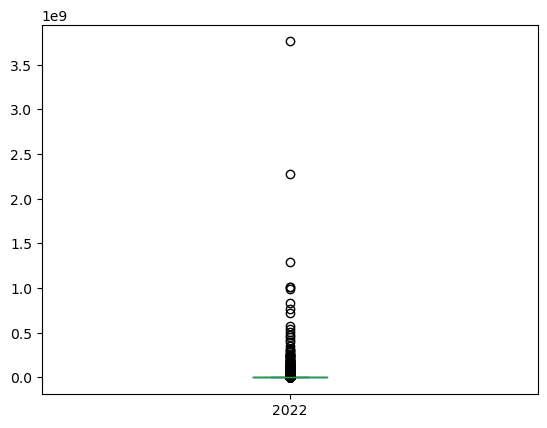

In [10]:
df_gdp1['2022'].plot(kind='box')

In [11]:
df_gdp1.sort_values(by='2022', ascending=False)

,FIPS,GeoName,IndustryClassification,Description,2022
31,0,United States,"31-33,51",Manufacturing and information,3.758807e+09
6,0,United States,31-33,Manufacturing,2.277757e+09
7,0,United States,"321,327-339",Durable goods manufacturing,1.296970e+09
30,0,United States,"22,48-49",Transportation and utilities,1.016053e+09
108049,98000,Far West,"31-33,51",Manufacturing and information,1.010181e+09
...,...,...,...,...,...
87009,47167,"Tipton, TN",21,"Mining, quarrying, and oil and gas extraction",0.000000e+00
62659,35019,"Guadalupe, NM","31-33,51",Manufacturing and information,0.000000e+00
16221,13149,"Heard, GA",21,"Mining, quarrying, and oil and gas extraction",0.000000e+00
16225,13149,"Heard, GA","321,327-339",Durable goods manufacturing,0.000000e+00


The Outliers are pobably FIPS = USA

In [12]:
#DROP USA. For the Use case only the county level is important
df_gdp1.drop(df_gdp1[df_gdp1['FIPS'] == 0].index, inplace=True)

Are there only the relevant 2 Digit naics?

In [13]:
#Looking for the unique values in the column naics
df_gdp1['IndustryClassification'].unique()

array(['11', '21', '22', '23', '31-33', '321,327-339', '311-316,322-326',
       '11,21', '22,48-49', '31-33,51'], dtype=object)

#### Second Selection: Remove aggregated values

In [14]:
naics_to_drop= ['11,21', '22,48-49', '31-33,51']    
df_gdp1 = df_gdp1[~df_gdp1['IndustryClassification'].isin(naics_to_drop)]

Check the unique naics again

In [15]:
df_gdp1['IndustryClassification'].unique()

array(['11', '21', '22', '23', '31-33', '321,327-339', '311-316,322-326'],
      dtype=object)

## Data Frame Occupation

In [16]:
df_occ1= df_occ.copy()

### First selection: Important sectors

In [17]:
df_occ1= df_occ1[df_occ1['naics'].str.startswith(('11','21','22,''23', '31', '32', '33'))]

In [18]:
df_occ1.shape

(475212, 8)

In [19]:
df_occ1.head()

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation
5,13073,13,3211,Sawmills and Wood Preservation,116,11-3051,Industrial Production Managers,0.978609
6,13073,13,3219,Other Wood Product Manufacturing,27,11-3051,Industrial Production Managers,0.258713
7,13073,13,3231,Printing and Related Support Activities,24,11-3051,Industrial Production Managers,0.258713
8,13073,13,3327,"Machine Shops; Turned Product; and Screw, Nut,...",18,11-3051,Industrial Production Managers,0.314955
9,13073,13,3363,Motor Vehicle Parts Manufacturing,58,11-3051,Industrial Production Managers,0.933616


In [20]:
#is USA in?
df_occ1.sort_values(by='FIPS', ascending= True)

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation
1170765,1001,1,3231,Printing and Related Support Activities,33,51-9031,"Cutters and Trimmers, Hand",0.064068
1113483,1001,1,2123,Nonmetallic Mineral Mining and Quarrying,87,49-9071,"Maintenance and Repair Workers, General",3.632929
1044708,1001,1,2123,Nonmetallic Mineral Mining and Quarrying,87,17-2141,Mechanical Engineers,0.062086
1051579,1001,1,2123,Nonmetallic Mineral Mining and Quarrying,87,17-3026,Industrial Engineering Technologists and Techn...,0.058004
1079945,1001,1,1133,Logging,68,49-3031,Bus and Truck Mechanics and Diesel Engine Spec...,0.942842
...,...,...,...,...,...,...,...,...
1805903,56999,56,2111,Oil and Gas Extraction,162,49-9043,"Maintenance Workers, Machinery",1.089159
1805904,56999,56,2131,Support Activities for Mining,1051,49-9043,"Maintenance Workers, Machinery",5.927052
1796596,56999,56,2131,Support Activities for Mining,1051,47-5022,Excavating and Loading Machine and Dragline Op...,1.864844
1789782,56999,56,2111,Oil and Gas Extraction,162,11-3051,Industrial Production Managers,4.541100


### Data Understanding
In the Occupation dataset, there are many different occupations, but not all are relevant for our use case. We need to identify which occupations are important for us. To achieve this, we must determine the top 30 occupations that could use the products our business sells, such as hand tools for the metalworking industry.

In [21]:
df_occ1['OCC_CODE'].unique()

array(['11-3051', '17-2011', '17-2112', '17-2131', '17-2141', '17-2151',
       '17-3021', '17-3026', '17-3027', '45-2091', '45-4021', '45-4022',
       '47-2011', '47-2043', '47-2211', '47-2221', '47-5012', '47-5013',
       '47-5022', '47-5041', '47-5044', '47-5049', '47-5051', '49-3011',
       '49-3021', '49-3023', '49-3031', '49-3041', '49-3042', '49-3043',
       '49-3051', '49-3093', '49-9041', '49-9043', '49-9044', '49-9071',
       '51-2011', '51-2031', '51-2041', '51-4021', '51-4022', '51-4023',
       '51-4031', '51-4032', '51-4033', '51-4034', '51-4035', '51-4041',
       '51-4051', '51-4052', '51-4061', '51-4062', '51-4071', '51-4072',
       '51-4081', '51-4111', '51-4121', '51-4122', '51-4191', '51-4193',
       '51-4194', '51-4199', '51-7031', '51-7042', '51-7099', '51-9021',
       '51-9022', '51-9031', '51-9032', '51-9041', '51-9051', '51-9081',
       '51-9082', '51-9195', '17-2121', '47-5011', '49-9081', '51-7032',
       '47-5043'], dtype=object)

#### What branch is important for our use case? 
To determine which occupations are relevant, we need to apply business understanding. Let's examine the key industries and the tools the company sells:

Industries with Wide Usage:

- Aerospace, space, and gas turbine industries
- Robotics - Professional tools for automated processes
- Chemical and process industries
- Equipment and container construction
- Steelworks
- Foundries
- Tool and mold making
- Pipeline construction
- Shipyards
- Vehicle construction
- Steel construction and locksmithing
- Mechanical engineering

Tools:

- Files
- Milling, drilling, and countersinking tools
- Grinding pins and grinding wheels
- Fine grinding and polishing tools
- Diamond and CBN tools
- Cutting, flap, and roughing discs
- Cutting discs for stationary use
- Technical brushes
- Tool drives
- Cutting tools for stationary use

##### Occupations to delete
- 11 -> Managment Jobs
- 17 -> Ingeneure
- 45 -> Farmin Fishing Foresty
- 51-7000 -> Woodworkers





### Final top 30 Occupation

We are looking to identify the top 30 occupations that, based on business understanding, might use the products (hand tools for metalworking) we sell.

In [22]:
occ_30 = ["51-4023","51-4031", "51-4032", "51-4033", "51-4034", "51-4035", "51-4041", "51-4121", "51-4122",
            "51-4191", "51-4193", "51-4194", "51-4199", "49-3023", "49-3031", "47-2221", "49-3042", "49-9041", "49-9043",
            "49-9071", "51-2041", "51-9021", "51-9022", "51-9031", "51-9032", "51-9041", "49-3041", "51-4072"]

Delete every row where the occupation code is not in the list

In [23]:
df_occ1= df_occ1[df_occ1['OCC_CODE'].isin(occ_30)]

In [24]:
#show the unqiue occupation code
df_occ1['OCC_CODE'].unique()

array(['47-2221', '49-3023', '49-3031', '49-3041', '49-3042', '49-9041',
       '49-9043', '49-9071', '51-2041', '51-4023', '51-4031', '51-4032',
       '51-4033', '51-4034', '51-4035', '51-4041', '51-4072', '51-4121',
       '51-4122', '51-4191', '51-4193', '51-4194', '51-4199', '51-9021',
       '51-9022', '51-9031', '51-9032', '51-9041'], dtype=object)

In [25]:
unique_occ= df_occ1[['OCC_CODE','OCC_TITLE']].drop_duplicates()
unique_occ

,OCC_CODE,OCC_TITLE
32950,47-2221,Structural Iron and Steel Workers
42395,49-3023,Automotive Service Technicians and Mechanics
48522,49-3031,Bus and Truck Mechanics and Diesel Engine Spec...
55307,49-3041,Farm Equipment Mechanics and Service Technicians
57115,49-3042,"Mobile Heavy Equipment Mechanics, Except Engines"
66765,49-9041,Industrial Machinery Mechanics
73408,49-9043,"Maintenance Workers, Machinery"
81863,49-9071,"Maintenance and Repair Workers, General"
92327,51-2041,Structural Metal Fabricators and Fitters
96466,51-4023,"Rolling Machine Setters, Operators, and Tender..."


later we wil only use top 3 occupations for every naics

### Second Selection: Top 5 naics
Determine the top 5 naics by total employees

In [26]:
Top5_occ= df_occ1.groupby(["naics","NAICS_TITLE"]).agg({
    'emp_total_county_naics':lambda x: x.unique().sum(),
    "emp_occupation": lambda x: x.unique().sum(),})
Top5_occ= Top5_occ.sort_values(by=['emp_total_county_naics'],ascending= False)
Top5_occ

,,emp_total_county_naics,emp_occupation
naics,NAICS_TITLE,,
3261,Plastics Product Manufacturing,516677,201694.663864
3330A1,"3331, 3332, 3334, 3339",458527,136426.886782
3363,Motor Vehicle Parts Manufacturing,446788,137966.879779
3345,"Navigational, Measuring, Electromedical, and Control Instruments Manufacturing",355947,19077.952020
3364,Aerospace Product and Parts Manufacturing,343769,42354.259258
3231,Printing and Related Support Activities,310560,17355.914888
3320A1,"3321, 3322, 3325, 3326, 3329",287792,110713.002316
3320A2,"3323, 3323",275846,147896.096488
3327,"Machine Shops; Turned Product; and Screw, Nut, and Bolt Manufacturing",258800,161713.910990


The top 5 naics are not realy relevant for the business. 
We are looking for Sectors that are interesting for the Business.
So again we have to determine the top 5 naics by Business Understanding:
1. 3330A1 - 3331, 3332, 3334, 3339
2. 3363 - Motor Vehicle Parts Manufacturing 
3. 3364 - Aerospace Product and Parts Manufacturing 
4. 3320A1 - 3321, 3322, 3325, 3326, 3329
5. 3327 - Machine Shops; Turned Product; and Screw, Nut, and Bolt Manufacturing

In [27]:
Top5_occ= ['3327','3320A1','3364','3363','3330A1']

Delete every row not in the list.

In [28]:
df_occ1= df_occ1[df_occ1['naics'].isin(Top5_occ)]

### Third Selection: Top 3 occupations by frequency

In the next steps, further selection will be performed. From the top 30 occupations, we will select the top 3 occupations for each NAICS code and FIPS Code.

#### Option 1: Fixed values (not good enaugh)

In [30]:
df_occ1['OCC_CODE'].value_counts().head(5)

OCC_CODE
51-4041    3153
51-4121    3153
49-9041    3153
49-9071    3153
51-4031    3151
Name: count, dtype: int64

In [207]:
#top 3 berufe fixed
metal_work_occupations = ['49-9071', '51-4121',  '51-4041']
df_occ1 = df_occ1[df_occ1['OCC_CODE'].isin(metal_work_occupations)]
df_occ1[(df_occ1['FIPS']==1003)&(df_occ1['naics']=='3320A1')]

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation
1113540,1003,1,3320A1,"3321, 3322, 3325, 3326, 3329",72,49-9071,"Maintenance and Repair Workers, General",2.226634
1138425,1003,1,3320A1,"3321, 3322, 3325, 3326, 3329",72,51-4041,Machinists,4.200614
1151692,1003,1,3320A1,"3321, 3322, 3325, 3326, 3329",72,51-4121,"Welders, Cutters, Solderers, and Brazers",7.259195


#### Option 2: Dynamic calculation 

In [31]:
#top 3 berufe dynamisch 
df_occ1= df_occ1.sort_values(by=['FIPS','naics','emp_occupation'],ascending=[True, True, False])
df_occ1= df_occ1.groupby(['FIPS', 'naics']).head(3)
df_occ1.head()

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation
1130466,1003,1,3320A1,"3321, 3322, 3325, 3326, 3329",72,51-4031,"Cutting, Punching, and Press Machine Setters, ...",7.837217
1151692,1003,1,3320A1,"3321, 3322, 3325, 3326, 3329",72,51-4121,"Welders, Cutters, Solderers, and Brazers",7.259195
1138425,1003,1,3320A1,"3321, 3322, 3325, 3326, 3329",72,51-4041,Machinists,4.200614
1138427,1003,1,3327,"Machine Shops; Turned Product; and Screw, Nut,...",85,51-4041,Machinists,26.567868
1151694,1003,1,3327,"Machine Shops; Turned Product; and Screw, Nut,...",85,51-4121,"Welders, Cutters, Solderers, and Brazers",6.376564


##### Test

In [32]:
df_occ1[(df_occ1['FIPS']==1003)&(df_occ1['naics']=='3320A1')]

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation
1130466,1003,1,3320A1,"3321, 3322, 3325, 3326, 3329",72,51-4031,"Cutting, Punching, and Press Machine Setters, ...",7.837217
1151692,1003,1,3320A1,"3321, 3322, 3325, 3326, 3329",72,51-4121,"Welders, Cutters, Solderers, and Brazers",7.259195
1138425,1003,1,3320A1,"3321, 3322, 3325, 3326, 3329",72,51-4041,Machinists,4.200614


#### Advantages of Dynamic Calculation:

For each FIPS code and NAICS code, the top 3 occupations are calculated dynamically. Fixed values may not be optimal because different occupations could have better values for a given FIPS code. Additionally, the NAICS code should exist within the FIPS code; if it does, there will definitely be 3 occupations contributing to the metric emp_occupation.

In [33]:
df_occ1['OCC_CODE'].unique()

array(['51-4031', '51-4121', '51-4041', '51-4033', '49-9041', '51-4122',
       '49-9071', '51-4034', '49-9043', '51-4072', '51-4035', '51-4032'],
      dtype=object)

## Data Frame pattern

In [34]:
df_pattern1= df_pattern.copy()

## First Selection: Naics sectors

In [35]:
df_pattern1=df_pattern1[df_pattern1['naics_2'].str.startswith(('11','21','23', '31', '32', '33'))]

In [36]:
df_pattern1.shape

(29721, 26)

In [37]:
df_pattern1.head()

,State_GEOID,County_GEOID,FIPS,naics_2,naics,DESCRIPTION,emp_nf,emp,qp1_nf,qp1,...,n20_49,n50_99,n100_249,n250_499,n500_999,n1000,n1000_1,n1000_2,n1000_3,n1000_4
0,01,001,1001,11,1133,Logging,G,68,G,1213,...,N,N,N,N,N,N,N,N,N,N
1,01,001,1001,21,2123,Nonmetallic Mineral Mining and Quarrying,G,87,G,1224,...,N,N,N,N,N,N,N,N,N,N
4,01,001,1001,23,2362,Nonresidential Building Construction,H,69,H,685,...,N,N,N,N,N,N,N,N,N,N
5,01,001,1001,23,2371,Utility System Construction,H,65,H,1117,...,N,N,N,N,N,N,N,N,N,N
6,01,001,1001,23,2381,"Foundation, Structure, and Building Exterior C...",H,44,G,401,...,N,N,N,N,N,N,N,N,N,N


Replace N with 0

In [38]:
df_pattern1.replace('N', 0, inplace=True)

## Data Frames mergen

In [39]:
attributes_occupation = ["NAICS_TITLE",'emp_total_county_naics',"OCC_CODE","OCC_TITLE",'emp_occupation']
attributes_pattern = ["State_GEOID","naics_2",'emp', 'qp1','est']
df_combined = pd.merge(df_occ1[['FIPS',"naics"] + attributes_occupation],
                       df_pattern1[['FIPS',"naics"] + attributes_pattern],
                       on=['FIPS',"naics"], how='inner')

In [40]:
df_combined.shape

(12288, 12)

In [41]:
def map_naics_to_sector(naics):
    naics = str(naics) 
    
    
    naics_3digit = ''.join(filter(str.isdigit, naics[:3]))
    
    if naics.startswith('11'):
        return '11'
    elif naics.startswith('21'):
        return '21'
    elif naics.startswith('22'):
        return '22'
    elif naics.startswith('23'):
        return '23'
    elif naics_3digit in ['311', '312', '313', '314', '315', '316', '322', '323', '324', '325', '326']:
        return '311-316,322-326'
    elif naics_3digit == '321' or int(naics_3digit) >= 327:
        return '321,327-339'
    elif naics.startswith(('31', '32', '33')):
        return '31-33'
    else:
        return None  

In [42]:
df_combined['IndustryClassification'] = df_combined['naics'].apply(lambda x: map_naics_to_sector(x))
df_combined = pd.merge(df_combined, df_gdp1, on=['FIPS','IndustryClassification'], how = "inner")

In [43]:
df_combined.head()

,FIPS,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation,State_GEOID,naics_2,emp,qp1,est,IndustryClassification,GeoName,Description,2022
0,1003,3320A1,"3321, 3322, 3325, 3326, 3329",72,51-4031,"Cutting, Punching, and Press Machine Setters, ...",7.837217,01,33,72,930,5,"321,327-339","Baldwin, AL",Durable goods manufacturing,487152.0
1,1003,3320A1,"3321, 3322, 3325, 3326, 3329",72,51-4121,"Welders, Cutters, Solderers, and Brazers",7.259195,01,33,72,930,5,"321,327-339","Baldwin, AL",Durable goods manufacturing,487152.0
2,1003,3320A1,"3321, 3322, 3325, 3326, 3329",72,51-4041,Machinists,4.200614,01,33,72,930,5,"321,327-339","Baldwin, AL",Durable goods manufacturing,487152.0
3,1003,3327,"Machine Shops; Turned Product; and Screw, Nut,...",85,51-4041,Machinists,26.567868,01,33,85,938,10,"321,327-339","Baldwin, AL",Durable goods manufacturing,487152.0
4,1003,3327,"Machine Shops; Turned Product; and Screw, Nut,...",85,51-4121,"Welders, Cutters, Solderers, and Brazers",6.376564,01,33,85,938,10,"321,327-339","Baldwin, AL",Durable goods manufacturing,487152.0


## Cluster Data Frame

##### Pre Cluster Data Frame
The data frame should first be sorted by the relevant metrics and remove any irrelevant columns.


To achieve this, group the data frame by FIPS and NAICS codes and either sum the metrics or take the first value of each metric.

In [44]:
df_combined= df_combined.sort_values(by=['FIPS','naics','emp_occupation'],ascending=[True,True,False])
df_combined=df_combined.groupby(['FIPS','naics']).agg({
    'emp_occupation':'sum','2022':'first','qp1':'first','est':'first'
}).reset_index()

Display the new pre cluster Data Frame

In [45]:
df_combined

,FIPS,naics,emp_occupation,2022,qp1,est
0,1003,3320A1,19.297026,487152.0,930,5
1,1003,3327,37.411982,487152.0,938,10
2,1003,3330A1,63.680700,487152.0,6082,4
3,1003,3364,110.205722,487152.0,16633,6
4,1007,3327,7.053415,63767.0,196,3
...,...,...,...,...,...,...
3124,56029,3320A1,5.580862,32146.0,120,3
3125,56029,3327,14.224207,32146.0,415,5
3126,56033,3327,19.879000,63038.0,555,3
3127,56037,3327,6.291033,13374.0,158,3


##### Currently, clustering cannot be performed with the data frame because the FIPS codes must be unique. Additionally, the NAICS codes should be displayed as a separate column.

In [46]:
df_cluster = df_combined.pivot_table(index='FIPS', columns='naics', values='emp_occupation').reset_index()
df_to_be_merged= df_combined.groupby('FIPS').agg({
    'est':'sum', 'qp1':'mean','2022':'first'
}).reset_index()

df_cluster = pd.merge(df_cluster, df_to_be_merged,on='FIPS')
df_cluster.fillna(0, inplace=True)
df_cluster

,FIPS,3320A1,3327,3330A1,3363,3364,est,qp1,2022
0,1003,19.297026,37.411982,63.680700,0.000000,110.205722,25,6145.750000,487152.0
1,1007,0.000000,7.053415,0.000000,0.000000,0.000000,3,196.000000,63767.0
2,1009,0.000000,28.168724,0.000000,0.000000,0.000000,7,656.000000,53999.0
3,1015,201.303245,79.701043,0.000000,0.000000,0.000000,19,6861.000000,943623.0
4,1017,0.000000,0.000000,0.000000,187.491951,0.000000,6,8588.000000,207519.0
...,...,...,...,...,...,...,...,...,...
1387,56025,16.802817,27.302142,227.569601,0.000000,0.000000,28,2885.333333,0.0
1388,56029,5.580862,14.224207,0.000000,0.000000,0.000000,8,267.500000,32146.0
1389,56033,0.000000,19.879000,0.000000,0.000000,0.000000,3,555.000000,63038.0
1390,56037,0.000000,6.291033,0.000000,0.000000,0.000000,3,158.000000,13374.0


## Step 3: Clustering

#### Format FIPS code as a 5-digit code

In [47]:
df_cluster['FIPS'] = df_cluster['FIPS'].astype(str)
df_cluster['FIPS'] = df_cluster['FIPS'].apply(lambda x: x.zfill(5))

### K-means Clustering

In [48]:
df_selected = df_cluster[[ "3320A1","3327","3330A1","3363","3364", 'qp1', 'est','2022']]

In [49]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

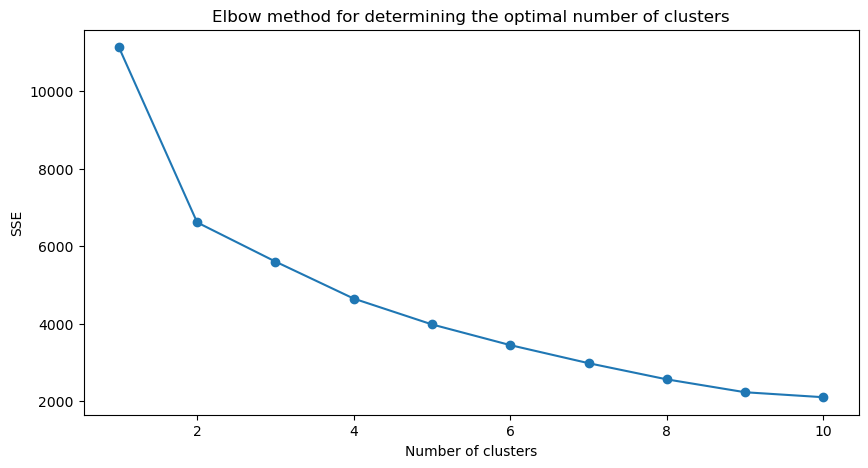

In [51]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow method for determining the optimal number of clusters')
plt.show()

In [52]:
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42,n_init=10)
df_cluster['kmeans_cluster'] = kmeans.fit_predict(df_scaled)

Cluster size

In [53]:
df_cluster['kmeans_cluster'].value_counts()

kmeans_cluster
0    1291
2      84
1      17
Name: count, dtype: int64

In [54]:
cluster_stats = df_cluster.groupby('kmeans_cluster')[df_selected.columns].mean()
cluster_stats

,3320A1,3327,3330A1,3363,3364,qp1,est,2022
kmeans_cluster,,,,,,,,
0,36.273909,49.279204,70.127861,31.062486,3.602201,2923.918965,14.542215,4.549642e+05
1,3543.368820,1492.663041,3221.781597,823.139416,799.805123,109816.514706,383.647059,2.005307e+07
2,913.264356,417.924080,1381.564749,289.928317,79.349418,21502.005556,90.726190,3.487299e+06


## Step 4: Geovisualization

### Load Data

In [55]:
state_shape = pd.read_pickle('statepickle.sec')
county_shape = pd.read_pickle('countypickle.sec')

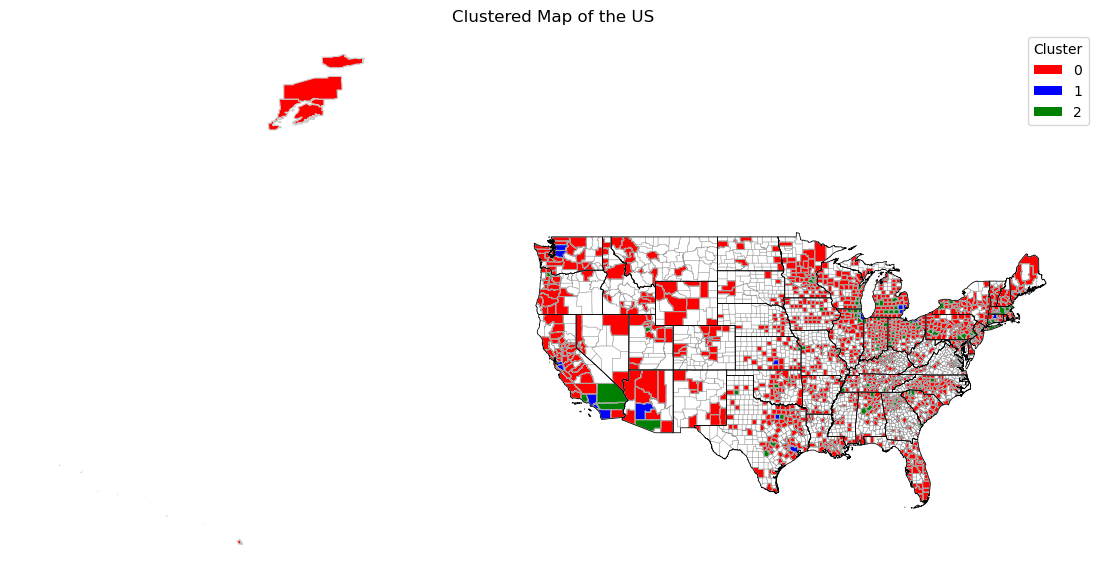

In [63]:
county_shape = county_shape.rename(columns={'GEOID': 'FIPS'})

filtered_statefp = state_shape.loc[~state_shape['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico', 'Commonwealth of the Northern Mariana Islands', 'American Samoa', 'United States Virgin Islands', 'Guam']), 'STATEFP']
filtered_state_shape = state_shape[state_shape['STATEFP'].isin(filtered_statefp)]
filtered_county_shape = county_shape[county_shape['STATEFP'].isin(filtered_statefp)]

code_to_color = {
    1: 'blue',
    2: 'green',
    0: 'red'
    }

result_df = df_cluster.copy()
result_df['Color'] = result_df['kmeans_cluster'].map(code_to_color)
merged_df = result_df.merge(county_shape, on='FIPS') 
result_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')

fig, ax = plt.subplots(figsize=(15, 7)) 
for cluster, cluster_df in result_gdf.groupby('kmeans_cluster'):
    cluster_color = cluster_df['Color'].iloc[0]  
    if isinstance(cluster_color, str):  
        cluster_df.plot(ax=ax, linewidth=0.8, edgecolor='0.8', legend=True, color=cluster_color)

filtered_county_shape.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.4, alpha=0.5)
filtered_state_shape.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)



sorted_code_to_color = sorted(code_to_color.items(), key=lambda x: x[0])
legend_elements = [Patch(facecolor=color, label=str(code)) for code, color in sorted_code_to_color]

ax.legend(handles=legend_elements, title='Cluster', loc='best')

plt.title('Clustered Map of the US')
plt.axis('off')  
plt.show()